In [1]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import ecco_v4_py as ecco
import requests
import gc
import pandas as pd

In [2]:
from dask.distributed import Client

client = Client()
client.run(gc.collect)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 15.61 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:62466,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 15.61 GiB
Comm: tcp://127.0.0.1:62502,Total threads: 3
Dashboard: http://127.0.0.1:62503/status,Memory: 3.90 GiB
Nanny: tcp://127.0.0.1:62470,


In [3]:
ecco_dir_ = 'D:/ECCOv4_heat_transport'
otrans_ = 'ocean_transport_terms'

tr_fs_ = [f'{ecco_dir_}/{otrans_}/{f}' for f in os.listdir(f'{ecco_dir_}/{otrans_}') if '.nc' in f]
tr_fs_[0:4]

['D:/ECCOv4_heat_transport/ocean_transport_terms/OCEAN_3D_TEMPERATURE_FLUX_day_mean_2012-01-01_ECCO_V4r4_native_llc0090.nc',
 'D:/ECCOv4_heat_transport/ocean_transport_terms/OCEAN_3D_TEMPERATURE_FLUX_day_mean_2012-01-02_ECCO_V4r4_native_llc0090.nc',
 'D:/ECCOv4_heat_transport/ocean_transport_terms/OCEAN_3D_TEMPERATURE_FLUX_day_mean_2012-01-03_ECCO_V4r4_native_llc0090.nc',
 'D:/ECCOv4_heat_transport/ocean_transport_terms/OCEAN_3D_TEMPERATURE_FLUX_day_mean_2012-01-04_ECCO_V4r4_native_llc0090.nc']

In [4]:
aggregate_yearly = False

### Bodge and aggregate - transport terms

In [5]:
def add_time(ds):
    
    units, ref_date = ds.time.attrs['units'].split('since')
    
    ds['time'] = pd.date_range(start=ref_date, periods=ds.sizes['time'],
                               freq='D'
    )
    
    return ds

In [6]:
# aggregating datasets
years = ['2012','2013','2014','2015','2016','2017']

years_subs_={}
for y in years:
    yr_ls_ = [f for f in tr_fs_ if y in f]
    
    #print(len(yr_ls_), '',sep='\n')
    
    years_subs_[y] = yr_ls_


In [7]:
%%time

if aggregate_yearly:

    year_at_a_time = '2012'

    ds_ = add_time(
        xr.open_mfdataset(years_subs_[y],
                          decode_cf=False,
                          chunks={'time':30}
                         )
    )


CPU times: total: 0 ns
Wall time: 0 ns


In [8]:
%%time

save_dir_ = ecco_dir_+'/ocean_transport_terms_aggr/'

if aggregate_yearly:

    vars_ = ['ADVx_TH','DFxE_TH','ADVy_TH','DFyE_TH','ADVr_TH','DFrE_TH','DFrI_TH']

    for v in vars_:
    
        new_ds = ds_[v].load()
        new_ds.to_netcdf(save_dir_+f'{v}_{year_at_a_time}.nc')
    
    new_ds.close()

    del ds_, new_ds


CPU times: total: 0 ns
Wall time: 0 ns


### Test the aggregations

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
# get grid
os.listdir('./grid_dir')

['.ipynb_checkpoints',
 '14072594',
 'grid_llc90',
 'making_an_mitgcm_grid.ipynb',
 'mitgcm_grid.nc']

In [12]:
grid = xr.open_dataset('./grid_dir/mitgcm_grid.nc')

In [13]:
test_fs = [save_dir_+f for f in os.listdir(save_dir_)]
test_fs

['D:/ECCOv4_heat_transport/ocean_transport_terms_aggr/ADVr_TH_2012.nc',
 'D:/ECCOv4_heat_transport/ocean_transport_terms_aggr/ADVx_TH_2012.nc',
 'D:/ECCOv4_heat_transport/ocean_transport_terms_aggr/ADVy_TH_2012.nc',
 'D:/ECCOv4_heat_transport/ocean_transport_terms_aggr/DFrE_TH_2012.nc',
 'D:/ECCOv4_heat_transport/ocean_transport_terms_aggr/DFrI_TH_2012.nc',
 'D:/ECCOv4_heat_transport/ocean_transport_terms_aggr/DFxE_TH_2012.nc',
 'D:/ECCOv4_heat_transport/ocean_transport_terms_aggr/DFyE_TH_2012.nc']

In [18]:
%%time
test_read = xr.open_mfdataset(test_fs, chunks={'time':60})

test_read

CPU times: total: 109 ms
Wall time: 114 ms


<xarray.Dataset>
Dimensions:  (time: 366, i: 90, j: 90, k_l: 50, tile: 13, i_g: 90, k: 50, j_g: 90)
Coordinates:
  * time     (time) datetime64[ns] 1992-01-01T12:00:00 ... 1992-12-31T12:00:00
  * i        (i) int32 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * j        (j) int32 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k_l      (k_l) int32 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * tile     (tile) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k        (k) int32 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * j_g      (j_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
Data variables:
    ADVr_TH  (time, k_l, tile, j, i) float32 dask.array<chunksize=(60, 50, 13, 90, 90), meta=np.ndarray>
    ADVx_TH  (time, k, tile, j, i_g) float32 dask.array<chunksize=(60, 50, 13, 90, 90), meta=np.ndarray>
    ADVy_TH  (time, k, tile, j_g, i) float32 dask.array<chunksize=(60, 50, 13, 90, 90), meta=np.ndarray>
    DFrE_TH  (time, k_l, tile, j, i) float32 dask.array<chunksize=(60, 50, 13, 90, 90), meta=np.ndarray>
    DFrI_TH  (time, k_l, tile, j, i) float32 dask.array<chunksize=(60, 50, 13, 90, 90), meta=np.ndarray>
    DFxE_TH  (time, k, tile, j, i_g) float32 dask.array<chunksize=(60, 50, 13, 90, 90), meta=np.ndarray>
    DFyE_TH  (time, k, tile, j_g, i) float32 dask.array<chunksize=(60, 50, 13, 90, 90), meta=np.ndarray>

In [ ]:
X, Y, Z = 

-179.75 39.75
-180.0 40.0
-89.75 89.75
-90.0 90.0
40.250906039426525 179.74910396057348
40.00001 180.0
-89.75 89.75
-90.0 90.0


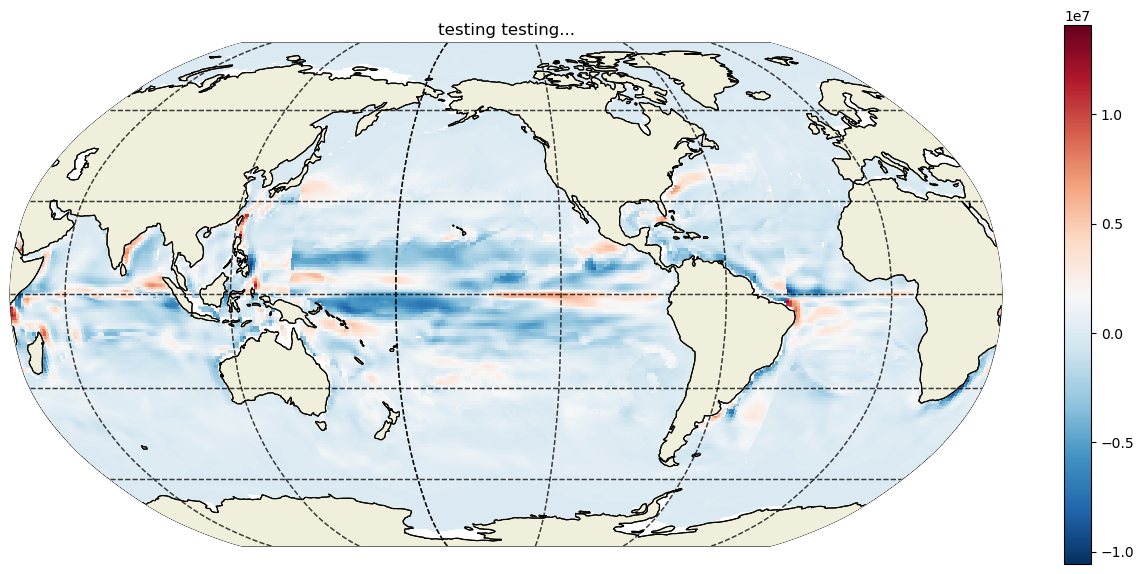

In [30]:
# test plot, seems the grid info is actually in the files, which is nice
# vdiff  = ds.DFrE_TH.isel(time=0, k_l=3)
# # mask to nan where hFacC(k=0) = 0
# #SSH  = SSH.where(grid.hFacC.isel(k=0))

fig  = plt.figure(figsize=(16,7))

ecco.plot_proj_to_latlon_grid(grid.XC, grid.YC, test_read.ADVy_TH.isel(time=100, k=3,),
                              user_lon_0=-140,
                              dx=0.5,
                              dy=0.5,
                              show_colorbar=True,
)
plt.title('testing testing...')
plt.show()


In [ ]:
%%time
test_read.ADVx_TH.isel(tile=7, k=0, i_g=50, j=50).plot()

### Clean up nb

In [31]:
client.shutdown()

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
distributed.utils - ERROR - object NoneType can't be used in 'await' expression
Traceback (most recent call last):
  File "C:\Users\uv20102\Anaconda3\envs\CMIP6_field_analysis_env\lib\site-packages\distributed\comm\tcp.py", line 205, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\uv20102\Anaconda3\envs\CMIP6_field_analysis_env\lib\site-packages\distributed\client.py", line 1222, in _handle_report
    msgs = await self.scheduler_comm.comm.read()
  File "C:\Users\uv20102\Anaconda3\envs\CMIP6_field_analysis_env\lib\site-packages\distributed\comm\tcp.py", line 221, in read
    convert_stream_closed_error(self, e)
  File "C:\Users\uv20102\Anaconda3\envs\CMIP6_field_analysis_env\lib\site-packages\distributed